In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error,root_mean_squared_error ##nmbe
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
import joblib
from sklearn.pipeline import Pipeline
import time 

In [2]:
### Annual data 
data=pd.read_csv("C:\\Users\\Elin Markarian\\OneDrive - Carleton University\\Optimization_Seif\\Datasets\\Dataset_01\\AnnualV01_Final.csv")

In [3]:
data.columns

Index(['Run', 'X1_WallR', 'X2_RoofR', 'X3_WindowU', 'X4_SHGC', 'X5_COPHigh',
       'X6_COPLow', 'X7_HSP(7-21)', 'X8_HSP(21-6)', 'X9_CSP(6-21)',
       'X10_CSP(21-6)', 'Total_Natural_Gas (GJ)', 'Unmet_ASHRAE_55 (hr)',
       'Peak_Electricity (W)'],
      dtype='object')

In [4]:
#### To store data in an excel file 
Algorithm='XGB'
time_window='annual'
transformer=''
scaling=''
target='Peak_Electricity (W)'

In [4]:
## To randomly choose the runs for training and testing: Only outputs the run number  
unique_runs = data['Run'].unique()
train_runs, test_runs = train_test_split(unique_runs, test_size=0.2, random_state=42)

In [5]:
# Filter the data based on the split Runs
data_train = data[data['Run'].isin(train_runs)].reset_index(drop=True)
data_test = data[data['Run'].isin(test_runs)].reset_index(drop=True)

In [6]:
## Split X_train, y_train, X_test and y_test
X_train= data_train[[ 
       'X1_WallR', 'X2_RoofR', 'X3_WindowU', 'X4_SHGC', 'X5_COPHigh',
       'X6_COPLow', 'X7_HSP(7-21)', 'X8_HSP(21-6)', 'X9_CSP(6-21)',
       'X10_CSP(21-6)']]
y_train= data_train['Peak_Electricity (W)']
X_test= data_test[[
       'X1_WallR', 'X2_RoofR', 'X3_WindowU', 'X4_SHGC', 'X5_COPHigh',
       'X6_COPLow', 'X7_HSP(7-21)', 'X8_HSP(21-6)', 'X9_CSP(6-21)',
       'X10_CSP(21-6)']]
y_test= data_test['Peak_Electricity (W)']

In [7]:
def compute_metrics (y_true, y_pred, n, k):  ## To calculate the metrics in one go instead of doing it separately for train and test sets 
    r2=r2_score(y_true, y_pred)
    adj_r2=1 - ((1 - r2) * (n - 1) / (n - k - 1))
    mae= mean_absolute_error(y_true, y_pred)
    mape= mean_absolute_percentage_error(y_true, y_pred)
    mse= mean_squared_error(y_true, y_pred)
    rmse= root_mean_squared_error(y_true, y_pred)
    cv_rmse= rmse/y_true.mean()
    mbe=sum(y_true-y_pred)/n
    nmbe= mbe/y_true.mean()
    metrics_dict = {
        'R2': [r2],
        'Adj_R2': [adj_r2],
        'MAE': [mae],
        'MAPE': [mape],
        'MSE': [mse],
        'RMSE': [rmse],
        'CV(RMSE)': [cv_rmse],
        'MBE': [mbe],
        'NMBE': [nmbe]
    }

    return metrics_dict 

In [8]:
def metrics(y_train_true, y_train_pred, y_test_true, y_test_pred, n_train, n_test, k): ## To sotre train and test metrcis in one row indf
    # Compute train and test metrics
    train_metrics = compute_metrics(y_train_true, y_train_pred, n_train, k)
    test_metrics = compute_metrics(y_test_true, y_test_pred, n_test, k)

    # Merge metrics with appropriate labels
    combined_metrics = {f"{name}_train": value for name, value in train_metrics.items()}
    combined_metrics.update({f"{name}_test": value for name, value in test_metrics.items()})
    df_metrics = pd.DataFrame(combined_metrics)

    return df_metrics

In [9]:
## ML Training and testing 
start_time=time.time()
reg=XGBRegressor(random_state=42)  ## Create an instance
# model = TransformedTargetRegressor(   ## SQRT transformer to prevent negative predictions 
#     regressor=reg,  
#     func=np.sqrt,
#     inverse_func=np.square,
#     #transformer=transformer,
#     check_inverse=True
# )
reg.fit(X_train,y_train)           ## Fit the model to the data
y_train_pred=reg.predict(X_train)  ## Use the fitted model to make predictions 
y_pred=reg.predict(X_test)
end_time=time.time()
run_time=end_time-start_time
df_metrics=metrics(y_train, y_train_pred, y_test, y_pred, len(X_train), len(X_test), len(X_train.columns))
df_metrics['run_time']=run_time

In [10]:
df_metrics

,R2_train,Adj_R2_train,MAE_train,MAPE_train,MSE_train,RMSE_train,CV(RMSE)_train,MBE_train,NMBE_train,R2_test,Adj_R2_test,MAE_test,MAPE_test,MSE_test,RMSE_test,CV(RMSE)_test,MBE_test,NMBE_test,run_time
0,1.0,1.0,7.343741,0.000035,109.03912,10.44218,0.000048,0.015566,7.104690e-08,0.932787,0.925235,5109.305894,0.023083,4.636093e+07,6808.886031,0.030763,-185.606744,-0.000839,0.162756


In [15]:
joblib.dump(reg, f'C:\\Users\\Elin Markarian\\OneDrive - Carleton University\\Optimization_Seif\\Models\\V1\\xgb_{target}_V1.sav')

['C:\\Users\\Elin Markarian\\OneDrive - Carleton University\\Optimization_Seif\\Models\\V1\\xgb_Peak_Electricity (W)_V1.sav']

In [14]:
model=joblib.load(f'C:\\Users\\Elin Markarian\\OneDrive - Carleton University\\Optimization_Seif\\Models\\V1\\xgb_Peak_Electricity (W)_V1.sav')

In [15]:
model

AttributeError: 'XGBModel' object has no attribute 'device'

AttributeError: 'XGBModel' object has no attribute 'device'

AttributeError: 'XGBModel' object has no attribute 'device'

In [20]:
#model=joblib.load(f'C:\\Users\\Elin Markarian\\OneDrive - Carleton University\\Optimization_Seif\\Models\\V1\\xgb_{target}_V1.sav')

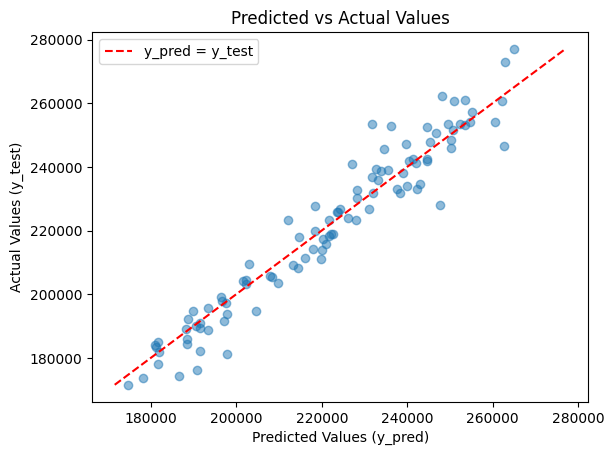

In [13]:
# Scatter plot of predicted vs actual values
plt.scatter(y_pred, y_test, alpha=0.5)

# Plot diagonal line (ideal case where y_pred == y_test)
plt.plot([min(min(y_pred), min(y_test)), max(max(y_pred), max(y_test))], 
         [min(min(y_pred), min(y_test)), max(max(y_pred), max(y_test))], 
         color='red', linestyle='--', label='y_pred = y_test')

# Labels and title
plt.xlabel('Predicted Values (y_pred)')
plt.ylabel('Actual Values (y_test)')
plt.title('Predicted vs Actual Values')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [17]:
y_pred.min()

177468.1

In [18]:
## Store the outputs in a xlsx file 
file_path = 'C:\\Users\\Elin Markarian\\OneDrive - Carleton University\\Optimization_Seif\\Models\\Metrics.xlsx'
df_result = pd.read_excel(file_path)

# Count the number of existing rows
num_existing_rows = len(df_result['Run'])

# Calculate the new value for the "Run" column
run_number = num_existing_rows + 1

# Add the 'Run' number and other metadata columns to df_metrics
df_metrics['Run'] = run_number
df_metrics['Time Window'] = time_window
df_metrics['Targets'] = target
df_metrics['Transformer'] = transformer
df_metrics['Scaling Method'] = scaling
df_metrics['Algorithm'] = Algorithm

column_order = [
    'Run', 'Time Window', 'Targets', 'Algorithm', 'Transformer', 
    'Scaling Method', 'R2_train', 'Adj_R2_train', 'MAE_train', 
    'MAPE_train', 'MSE_train', 'RMSE_train', 'CV(RMSE)_train', 'MBE_train', 
    'NMBE_train', 'R2_test', 'Adj_R2_test', 'MAE_test', 'MAPE_test', 'MSE_test',
    'RMSE_test', 'CV(RMSE)_test', 'MBE_test', 'NMBE_test', 'run_time'
]

# Reorder the columns of df_metrics according to the specified order
df_metrics = df_metrics[column_order]
# Append the new data (stored in df_metrics) to the existing DataFrame
df_result = pd.concat([df_result, df_metrics], ignore_index=True)

# Write the updated DataFrame to the Excel file
df_result.to_excel(file_path, index=False)